# Waste Image Classification

This set of notebooks implements an end-to-end image classification scenario. It uses the UC [RealWaste](https://archive.ics.uci.edu/dataset/908/realwaste) image set which consists of 4750 images of trash which are classified into 9 types. 

We then downsample the dataset to get a fast run time. THIS IS FOR API DEMONSTRATION PURPOSES ONLY. 

The resulting file `real_waste_data_sampled.csv` is checked into the repo. Unless you want to change the way it was extracted, you can simply use that file. The variable, PROCESS_DATA, controls whether to extract the data gain, otherwise this notebook will simply upload data to the AI Catalog.  



In [1]:
PROCESS_DATA = False

In [6]:
import zipfile
import base64
import csv
from collections import defaultdict
from pathlib import Path
import io
from PIL import Image

def get_class_from_filename(filename):
    parts = Path(filename).parts
    if len(parts) >= 4:
        return parts[2]
    return "unknown"

def get_file_extension(filename):
    return Path(filename).suffix.lower()[1:]

def process_zip_archive(zip_path, output_csv_path, min_samples=50, target_size=(224, 224)):
    extension_counts = defaultdict(int)
    class_counts = defaultdict(int)
    class_files = defaultdict(list)
    
    # First pass: count files and organize by class
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_info in zip_ref.filelist:
            if file_info.filename.endswith('/'):
                continue
                
            extension = get_file_extension(file_info.filename)
            extension_counts[extension] += 1
            
            if extension == 'jpg':
                class_name = get_class_from_filename(file_info.filename)
                class_counts[class_name] += 1
                class_files[class_name].append(file_info.filename)
    
    # Print initial summaries
    print("\nInitial File Extension Summary:")
    for ext, count in extension_counts.items():
        print(f"{ext.upper()}: {count} files")
        
    print("\nInitial Class Distribution Summary:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} files")
    
    # Calculate sampling rates
    sampling_rates = {}
    for class_name, count in class_counts.items():
        if count > min_samples:
            sampling_rates[class_name] = min_samples / count
        else:
            sampling_rates[class_name] = 1.0
    
    # Second pass: process images and write to CSV
    with zipfile.ZipFile(zip_path, 'r') as zip_ref, \
         open(output_csv_path, 'w', newline='') as csvfile:
        
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['main_class', 'image'])
        
        final_counts = defaultdict(int)
        
        for class_name, files in class_files.items():
            sampling_rate = sampling_rates[class_name]
            
            for idx, filename in enumerate(files):
                # Determine if we should process this file based on sampling rate
                if idx % (1/sampling_rate) != 0 and final_counts[class_name] >= min_samples:
                    continue
                
                # Read and process image
                with zip_ref.open(filename) as image_file:
                    # Open image with PIL for resizing
                    img = Image.open(io.BytesIO(image_file.read()))
                    
                    # Convert to RGB if necessary
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    
                    # Resize image
                    img = img.resize(target_size, Image.Resampling.LANCZOS)
                    
                    # Save to bytes
                    img_byte_arr = io.BytesIO()
                    img.save(img_byte_arr, format='JPEG', quality=85)
                    img_byte_arr = img_byte_arr.getvalue()
                    
                    # Convert to base64
                    base64_image = base64.b64encode(img_byte_arr).decode('utf-8')
                
                # Write to CSV
                csv_writer.writerow([class_name, base64_image])
                final_counts[class_name] += 1
                
                # Optional: Print progress
                if final_counts[class_name] % 10 == 0:
                    print(f"Processed {final_counts[class_name]} images for {class_name}")
    
    # Print final summary
    print("\nFinal Class Distribution Summary:")
    for class_name, count in final_counts.items():
        print(f"{class_name}: {count} files")

# Usage
zip_path = "data/realwaste.zip"  # Replace with your zip file path
output_csv_path = "data/real_waste_data_sampled.csv"
if PROCESS_DATA:
    try:
        process_zip_archive(zip_path, output_csv_path)
        print(f"\nProcessing complete. CSV file saved as: {output_csv_path}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


Initial File Extension Summary:
MD: 1 files
JPG: 4752 files

Initial Class Distribution Summary:
Cardboard: 461 files
Food Organics: 411 files
Glass: 420 files
Metal: 790 files
Miscellaneous Trash: 495 files
Paper: 500 files
Plastic: 921 files
Textile Trash: 318 files
Vegetation: 436 files
Processed 10 images for Cardboard
Processed 20 images for Cardboard
Processed 30 images for Cardboard
Processed 40 images for Cardboard
Processed 50 images for Cardboard
Processed 10 images for Food Organics
Processed 20 images for Food Organics
Processed 30 images for Food Organics
Processed 40 images for Food Organics
Processed 50 images for Food Organics
Processed 10 images for Glass
Processed 20 images for Glass
Processed 30 images for Glass
Processed 40 images for Glass
Processed 50 images for Glass
Processed 10 images for Metal
Processed 20 images for Metal
Processed 30 images for Metal
Processed 40 images for Metal
Processed 50 images for Metal
Processed 10 images for Miscellaneous Trash
Proc

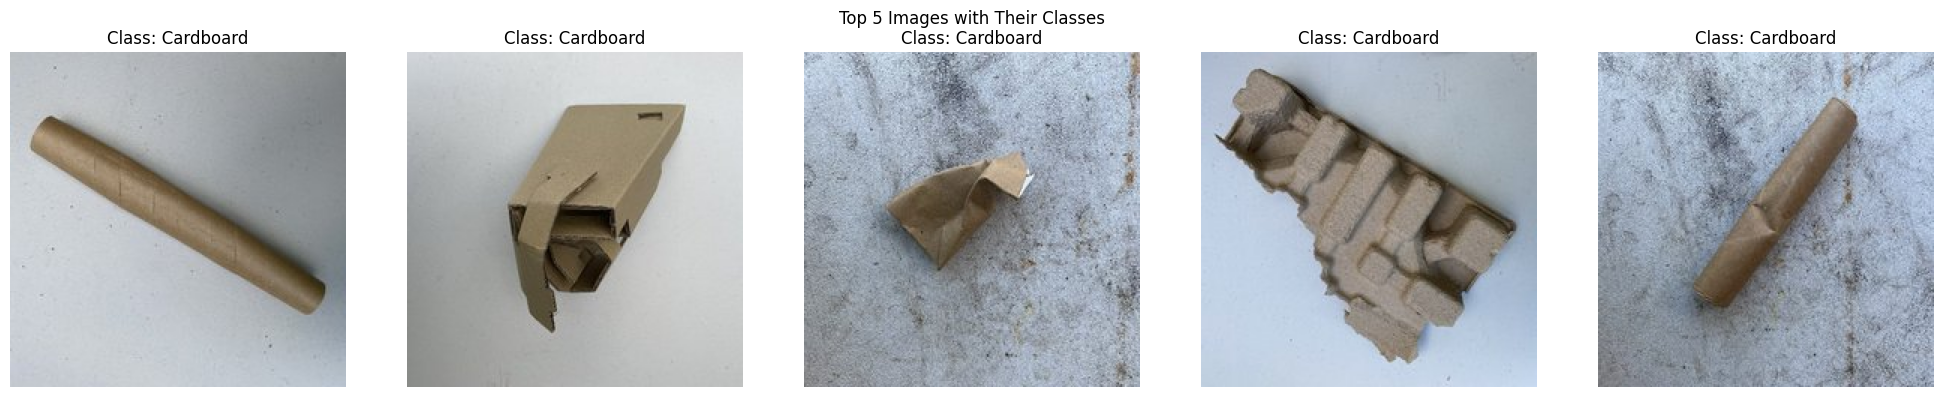

In [7]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from PIL import Image
import csv
import sys

# Increase CSV field size limit
maxInt = sys.maxsize
while True:
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

def display_top_images(csv_path, n=5):
    """
    Display the first n images from the CSV file without loading entire file into memory.
    
    Args:
        csv_path (str): Path to the CSV file
        n (int): Number of images to display (default: 5)
    """
    # Create a subplot grid
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    fig.suptitle('Top 5 Images with Their Classes')
    
    # Read CSV iteratively
    with open(csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        
        # Process only first n rows
        for idx in range(n):
            try:
                row = next(reader)
                
                # Decode base64 string to image
                img_data = base64.b64decode(row['image'])
                img = Image.open(BytesIO(img_data))
                
                # Display the image
                axes[idx].imshow(img)
                axes[idx].axis('off')
                axes[idx].set_title(f"Class: {row['main_class']}")
                
            except StopIteration:
                # If we run out of rows, clear the unused subplots
                for j in range(idx, n):
                    axes[j].axis('off')
                break
    
    plt.tight_layout()
    plt.show()

# Usage
csv_path = "data/real_waste_data_sampled.csv"

display_top_images(csv_path)

In [1]:
import datarobot as dr 

# Create your client
dr.Client()

dataset = dr.Dataset.create_from_file("data/real_waste_data_sampled.csv")
dataset.modify(name="Waste Class Images (Sampled)")
dataset.update()

print(f"The dataset ID is {dataset.id}")

The dataset ID is 6759ceeae340977868ae9eda
